# OpFlow codomain 1D GP data experiment


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
import timeit

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm

In [19]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## dataset parameters and preparation

In [20]:
ntrain = 30000
ndim = 256
batch_size = 512

nchannel = 2

length_scale_x = 0.5
nu_x = 0.5

length_scale_z = 0.1
nu_z = 0.5

In [21]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm
def GaussianProcess_1C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel=1):
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    #y_samples = gpr_model.sample_y(X, n_samples)
    
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim, n_samples, nchannel]).shape)        
    
    if return_kernel:
        return torch.tensor(y_samples), kernel(X)
    else:
        return torch.tensor(y_samples)

Starting up. Generating GP samples
torch.Size([30000, 256, 2])


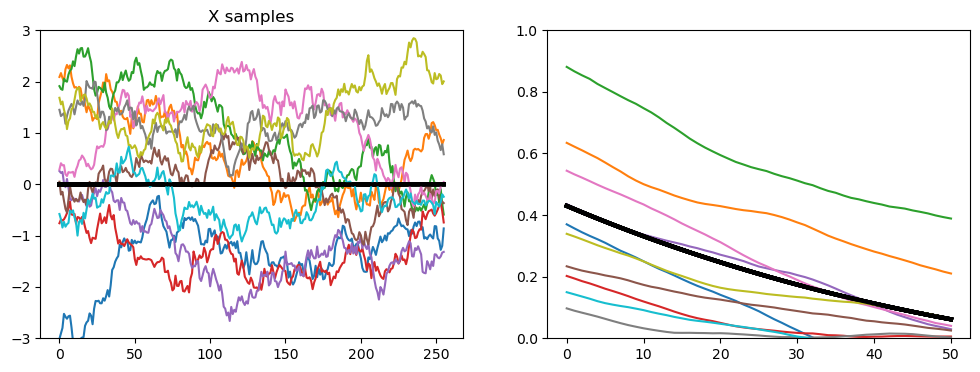

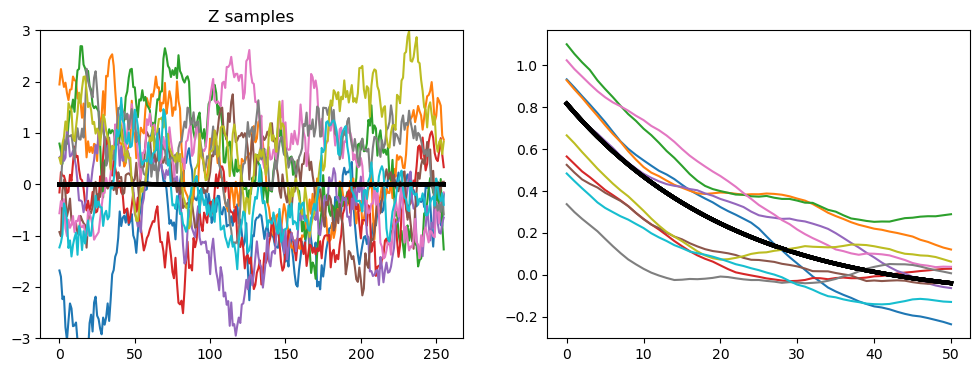

Finished sampling GRFs


In [22]:
print("Starting up. Generating GP samples")


np.random.seed(22)
# nu = 0.5, the smaller, the less smooth (more rough) the approximated function is
x_train = GaussianProcess_1C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0, 2])
fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=(0,2))
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,:,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()

# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(ndim, length_scale_z, nu_z, ntrain*2, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0, 2])
#z_train = torch.randn(z_train.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
z_mean_true = z_train.mean(dim=(0,2))
z_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(z_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
# rename as z_loader
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True)

for i in range(10):
    #x = grf.sample(1)[0,:,0]
    z = z_train[i,:,0]
    ax[0].plot(z)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(z_mean_true, c='k', lw=3)
    ax[1].plot(z_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(z, nlag=50))
    #ax[1].set_ylim([0.0, 1.0])
    ax[0].set_title("Z samples")
plt.show()
print("Finished sampling GRFs")

### OpFlow model setup

In [23]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, n=x.size(-1))
        x = torch.fft.irfft(out_ft)
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv1d(int(in_channel), int(out_channel), 1)

    def forward(self,x):
        
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [24]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        #self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = pointwise_op(self.width, self.width) #
        
        self.w1 = pointwise_op(self.width, self.width) #
        
        self.w2 = pointwise_op(self.width, self.width) #
        
        self.w3 = pointwise_op(self.width, self.width) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=2)
        
        x = self.fc0(x)
        x = F.gelu(x)
               
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [25]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
            std = input.std(dim=(0,1)).unsqueeze(0).unsqueeze(1)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [26]:
class AffineCoupling(nn.Module):
    def __init__(self, modes, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.modes = modes
        self.width = width
        self.coupling = FNO1d(modes=self.modes, width=self.width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        #
        x = z
        x, log_actnorm = self.actnorm(x)
        
        """
        n_rep = x.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=x.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:x.shape[1]]
        mask_b = torch.logical_not(mask_a)
        # define the dimension
        x1 = x * mask_a[None,:,None] # x1 has the same shape of z, but for False in mask_a, values are replaced with 0
        x2 = x * mask_b[None,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
        """
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,0:1]
        x2 = x[:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
    
        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,0:1]
        z2 = z[:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], 2]).shape)
        log_scale = scale_shift[:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [27]:
class OpFlow(nn.Module):
    def __init__(self, modes, width, blocks, base_dist, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]

        self.bijectors = nn.ModuleList([
            AffineCoupling(modes=modes, width=width) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [28]:
lr = 5*1e-5
epochs = 600
reg_fac = 1

n_train_tot = int(ntrain/batch_size)
modes = ndim // 4
width = 64
#width = 128


blocks = 10
base_mu = torch.zeros(ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [29]:
G = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)

#G = DDP(D, device_ids=device_ids, output_device=0)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
G.train()

Number generator parameters:  10739900


OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): SpectralConv1d()
        (conv1): SpectralConv1d()
        (conv2): SpectralConv1d()
        (conv3): SpectralConv1d()
        (w0): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w1): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w2): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w3): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): 

## Model training

In [30]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [31]:
def is_psd(mat):
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())


def matrix_sqrt(matrix):
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z_all, base_mu, base_cov):
    """
    z : [n, ndim, 2*ndim, 1]
    base_mu : [2*ndim*ndim]
    base_cov : [2*ndim*ndim, 2*ndim*ndim]
    """
    F2ID_all = 0
    for i in range(2):
        z = z_all[:,:,i]
        ndim = z.shape[1]
        syn_mu = z.mean(dim=0).reshape(ndim)
        syn_cov = torch.cov(z.reshape(-1, ndim).permute(1,0))

        """
        #print("syn_mu shape: {}, syn_cov shape : {}".format(syn_mu.shape, syn_cov.shape))

        if base_cov_sqrt is None:
            base_cov_sqrt = matrix_sqrt(base_cov).detach()

        #print("device of syn_cov :{}, base_cov:{}, syn_cov :{}, base_cov_sqrt:{}".format(syn_cov.device, base_cov.device, syn_cov.device, base_cov_sqrt.device))
        #L = syn_cov + base_cov - 2 * matrix_sqrt(base_cov_sqrt @ syn_cov @ base_cov_sqrt).cuda()
        #term1 = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim)
        #term2 = torch.trace(L)/(ndim*ndim)
        #F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.trace(L)/(ndim*ndim)    
        """

        F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim) + torch.sum((syn_cov -base_cov)**2)/(ndim)
        if i == 0:
            term1 = F2ID
        if i == 1:
            term2 = F2ID
        F2ID_all += F2ID
        #print('term1 : {}, term2 :{}'.format(term1, term2))
    return F2ID_all, term1, term2

## Training tricky for codomain OpFlow 

We may encounter instability when we train codomain OpFlow and may suddenly get extremely large F2ID regularization. To solve this, we compare the calculated F2ID regularization score for each iteration with historical regularizations score. If the F2ID score for current iteration exceeds the bound we set (ratio * median of historical regularization score), we set F2ID score as 0 for current iteration. The default ratio is 10. 

We found this strategy improves the performance of codomain OpFlow and can also be applied to challenging tasks when we use domain-decomposed OpFlow

In [32]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, scheduler=None, fine_tune_epoch=50, past_epoch=10):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)

    epochs = epochs + fine_tune_epoch
    
    losses_G = np.zeros(epochs)
    F2ID_past_epoch = torch.zeros(past_epoch) 
    
    for epoch in range(epochs):
        
        loss_G = 0.0
        losses_F2ID = [] # for training stability
        
        # fine tune phase
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1
        
        for j in range(n_train_tot):
            
            G_optim.zero_grad()
 
            x = get_x_batch().to(device)
            z_syn, log_pz, log_det = G(x)            
            ll_loss = (-log_pz - log_det).mean()


            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss, term1, term2 = cal_F2ID(z_syn, base_mu, base_cov)
                
                if epoch < past_epoch:
                    losses_F2ID.append(F2ID_loss.item())                    
                    loss = ll_loss + reg_fac*F2ID_loss
                    
                elif epoch >= past_epoch:
                    if (F2ID_loss >= 10 *torch.median(F2ID_past_epoch)): # set F2ID loss as 0, when it's abnormal
                        loss = ll_loss
                    else:
                        losses_F2ID.append(F2ID_loss.item())
                        loss = ll_loss + reg_fac*F2ID_loss
                    
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.2f}, loss_F2ID:{:.2f}, loss_F2ID term1:{:.2f}, loss_F2ID term2:{:.2f}".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item(), term1.item(), term2.item()))
            
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
            
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
            
        with torch.no_grad():
            F2ID_past_epoch[epoch%past_epoch] = torch.median(torch.Tensor(losses_F2ID))
            print("F2ID_past_epoch :{}".format(F2ID_past_epoch))            
            fig, ax = plt.subplots(2,2, figsize=(12,8))
            
            Z_alt = torch.cat([base_dist.rsample(sample_shape=(1000,)).reshape(-1, ndim, 1),
                               base_dist.rsample(sample_shape=(1000,)).reshape(-1, ndim, 1)], axis=-1)
            
            X_alt = G.inverse(Z_alt).detach().cpu()
            x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=50)) for i in range(1000)]).mean(dim=0)
            x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=50)) for i in range(1000)]).mean(dim=0)
            x_mean_channel1 = X_alt[:,:,0].mean(axis=0)
            x_mean_channel2 = X_alt[:,:,1].mean(axis=0)
            
            for i in range(10):
                x1 = X_alt[i,:,0]
                ax[0,0].plot(x1)

                x2 = X_alt[i,:,1]
                ax[1,0].plot(x2)
                
                ## acovf
                ax[0,1].plot(sm.tsa.acovf(x1, nlag=50))
                ax[1,1].plot(sm.tsa.acovf(x2, nlag=50))
                
                
                if i == 0:
                    ax[0,0].plot(x_mean_true, c='k', lw=3, label='Ground Truth')
                    ax[0,0].plot(x_mean_channel1, c='r', lw=3, label='Synthetic channel_1')
                    
                    ax[1,0].plot(x_mean_true, c='k', lw=3, label='Ground Truth')
                    ax[1,0].plot(x_mean_channel2, c='r', lw=3, label='Synthetic channel_2')
                    
                    ax[0,1].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')      
                    ax[0,1].plot(x_acovf_channel1, c='r', lw=3, label='Synthetic channel_1')
                    
                    ax[1,1].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')
                    ax[1,1].plot(x_acovf_channel2, c='r', lw=3, label='Synthetic channel_2')
                    
                    ax[0, 0].legend(loc='upper right')
                    ax[0, 1].legend(loc='upper right')
                    ax[1, 0].legend(loc='upper right')
                    ax[1, 1].legend(loc='upper right')
                    
            plt.savefig("../paper_plots/{}/1D_domain_decomposed_{}_set1.pdf".format(folder, epoch))
            plt.close()
      
        losses_G[epoch] = loss_G / batch_size
        
        if ((epoch+1)%300 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "../paper_saved_models/{}/1D_codomain_{}_set1.pt".format(folder, epoch))
        
    return losses_G

In [33]:
folder = "GP2GP_FNO_codomain_set1"
if not os.path.exists(f"../paper_saved_models/{folder}"):
    os.makedirs(f"../paper_saved_models/{folder}")
if not os.path.exists(f"../paper_plots/{folder}"):
    os.makedirs(f"../paper_plots/{folder}")

In [ ]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

## Validation

Text(0.5, 0, 'epoch')

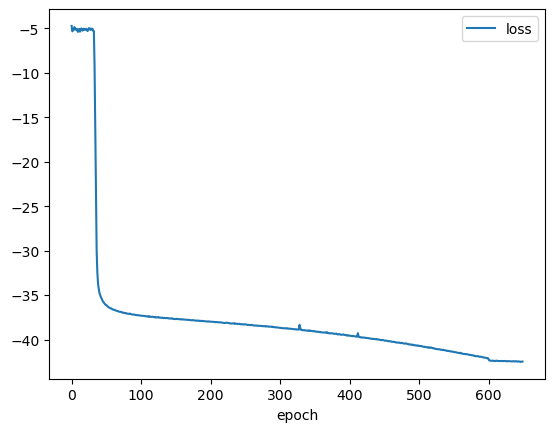

In [18]:
plt.plot(losses_G, label='loss')
plt.legend()
plt.xlabel('epoch')

In [38]:
folder = "GP2GP_FNO_codomain_set1"
if not os.path.exists(f"../paper_pdf/{folder}"):
    os.makedirs(f"../paper_pdf/{folder}")

In [13]:
# load trained model
G = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)


model_path = f"../paper_saved_models/{folder}/1D_codomain_649_set1.pt"
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [35]:
model = G

### Plot the contribution of the log_det from each block and final log_log
forward process, account the contribution of each block and 

In [39]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
nlag_eva = int(ndim//2)

x_pos = np.linspace(0, 1, ndim)
x_pos_acovf = x_pos[:nlag_eva]

nsample_eva = 5000

x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=nlag_eva-1)) for i in range(ntrain)]).mean(dim=0)

In [ ]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
    Z = torch.cat([base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1)], axis=-1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    X_ground_truth = x_train[:10]

    #Z_alt = base_dist.rsample(sample_shape=(1000,))[:,:,None]
    Z_alt = torch.cat([base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1)], axis=-1)    

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)  
    
    x_hist_channel1, bin_edges_alt = X_alt[:,:,0].histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt[:,:,1].histogram(range=[-5.5,5.5], density=True)  
    
    # plot first ground truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
    plt.title('Ground truth')
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_ground_truth.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,0]
        ax.plot(x_pos, x1)
    plt.title('OpFlow')
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")

    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,1]
        ax.plot(x_pos, x1)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")
        
    """

    #x_mean_channel1 = X_alt[:,:,0].mean(dim=0)
    #x_mean_channel2 = X_alt[:,:,1].mean(dim=0)
    x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)
    x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow channel')
    #ax.plot(x_pos_acovf, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel')
    
    ax.set_xlabel('Position')
    ax.set_title('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')
    ax.set_xlabel('Value')
    ax.set_title('Histogram')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_hist.pdf")

## Super-resolution

In [26]:
# nu = 0.5, the smaller, the less smooth (more rough) the approximated function is
ntrain_super = 5000
x_train = GaussianProcess_1C(2*ndim, length_scale_x, nu_x, ntrain_super, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0, 2])
    
# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(2*ndim, length_scale_z, nu_z, ntrain_super, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0, 2])


In [27]:
x_pos = np.linspace(0, 1, ndim*2)
x_pos_acovf = x_pos[:nlag_eva*2]

x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=2*nlag_eva-1)) for i in range(ntrain_super)]).mean(dim=0)

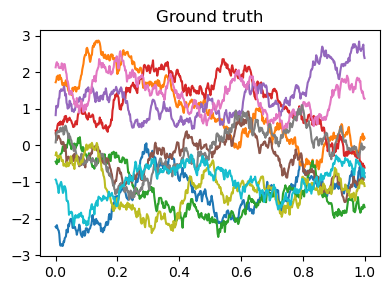

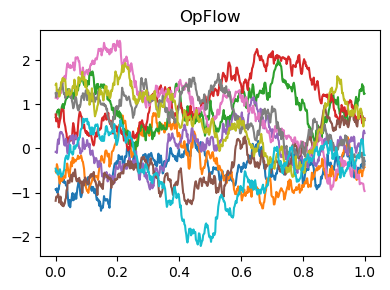

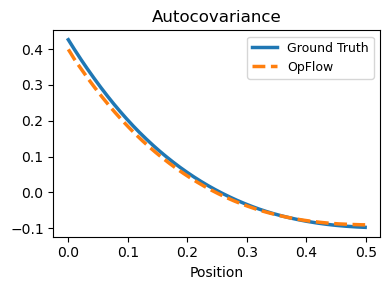

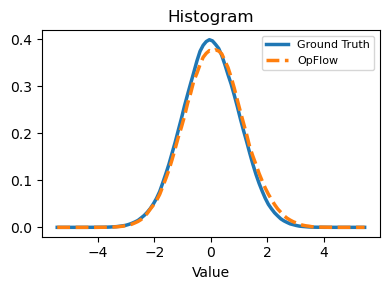

In [28]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(10,))[:,:,None]

    Z = z_train[10:20].to(device)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    
    X_ground_truth = x_train[:10]

    z_train_iter = torch.split(z_train, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)  
    
    x_hist_channel1, bin_edges_alt = X_alt[:,:,0].histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt[:,:,1].histogram(range=[-5.5,5.5], density=True)  
    
    # plot first ground truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
    plt.title('Ground truth')
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_ground_truth_sup.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,0]
        ax.plot(x_pos, x1)
    plt.title('OpFlow')
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel1_sup.pdf")

    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,1]
        ax.plot(x_pos, x1)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel2_sup.pdf")    
    """

    
    #x_mean_channel1 = X_alt[:,:,0].mean(dim=0)
    #x_mean_channel2 = X_alt[:,:,1].mean(dim=0)
    x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva*2-1)) for i in range(nsample_eva)]).mean(dim=0)
    x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=nlag_eva*2-1)) for i in range(nsample_eva)]).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.plot(x_pos_acovf, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel2')
    
    ax.set_xlabel('Position')
    ax.set_title('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov_sup.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')
    ax.set_xlabel('Value')
    ax.set_title('Histogram')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_hist_sup.pdf")